# Use PyMC Model for Bayes Hierarchical RL
- Estimate learning rate (i.e. alpha) for each subject using this model

In [21]:
%config Completer.use_jedi = False

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pytensor
import pytensor.tensor as pt
import scipy
import os
# import stan

import pymc as pm
import arviz as az
# import learning package
#import DMpy

In [22]:
# read scr file
#scr = pd.read_csv('/media/Data/Lab_Projects/PTSD_Reversal/Behavioral/SCR3.csv')
scr = pd.read_csv('behavior/SCR3.csv')
scr.head()


,Event.Nr,CDA.nSCR,CDA.Latency,CDA.AmpSum,CDA.SCR,CDA.ISCR,CDA.PhasicMax,CDA.Tonic,TTP.nSCR,TTP.Latency,TTP.AmpSum,Global.Mean,Global.MaxDeflection,Event.NID,Event.Name,Condition,group,sub
0,1,5,0.8435,0.2852,0.0003,0.1339,8.1296,2.3324,1,3.9335,0.5884,2.4822,0.5884,5,5,CSplusUS1,HC,189
1,2,4,0.7335,0.1033,0.0012,0.4737,0.3046,4.0029,0,NaN,0.0000,4.3933,0.0000,5,5,CSminus1,HC,189
2,3,3,2.9835,0.0783,0.0008,0.3237,0.1352,3.9579,1,2.8335,0.0260,3.9900,0.0154,5,5,CSplus1,HC,189
3,4,1,3.4935,0.1772,0.0002,0.0993,7.0748,3.8756,1,3.5335,0.5186,3.9212,0.5186,5,5,CSplusUS1,HC,189
4,5,0,NaN,0.0000,0.0004,0.1532,0.1604,4.2513,0,NaN,0.0000,4.3461,0.0000,5,5,CSminus1,HC,189


In [23]:
scr = scr[['sub','Condition','Event.Nr','CDA.AmpSum']]
scr['sub'] = scr['sub'].astype('string')
for i in scr.iterrows():
    if len(i[1]['sub'])<=2:
        #print(i[1]['sub'])
        sub = 'sub-0' + str(i[1]['sub'])
    else:
        sub = 'sub-' + str(i[1]['sub'])
    #print(sub)
    scr.at[i[0], 'sub'] = sub
    

In [24]:
len(scr['sub'].unique())

101

In [25]:
# grab subjects with 69 trials
scr_clean = scr.copy() # make a copy of original
for sub in scr['sub'].unique():
    df = scr[scr['sub']==sub]
    #print (len(df))
    if len(df)<69:
        scr_clean = scr_clean[scr_clean['sub']!=sub]
        
len(scr_clean['sub'].unique()) # total of 86 valid subjects


86

In [26]:
# grab just two subjects for now
scrTwo = scr_clean#[(scr['sub']==152) |(scr['sub']==189) | (scr['sub']==86) | (scr['sub']==48)]
scrTwo['Event.Nr'].values

array([ 1,  2,  3, ..., 67, 68, 69], shape=(5934,))

Organize the data for the analysis

In [27]:
# organize data accordingly
# first, grab just the relevant variables (subject, trial, stimuli, shock)
# we need to generate a new variable shock (1=yes, 0=no)
# we also need a new variable stim (1=CS+, 2=CS-)
scrVec = scrTwo['CDA.AmpSum'].values
print(scrVec.shape)
shockVec = np.zeros(len(scrVec), dtype=np.int32) # vector to capture shock (1=yes, 0=no)
stimVec = np.zeros(len(scrVec), dtype=np.int32) # vector to capture stimulus (1=CS+, 2= CS-)

for i, cond in enumerate(scrTwo['Condition'].values):
    if cond=='CSplusUS1':
        shockVec[i]= 1
        stimVec[i] = 1
    elif cond=='CSminusUS2':
            # after reversal so minus becomes plus
        shockVec[i]= 1
        stimVec[i] = 0
    elif cond=='CSplus2':
            # after reversal so plus becomes minus
            shockVec[i]=0
            stimVec[i] = 1
    elif cond=='CSplus1':
            stimVec[i] = 1
            shockVec[i]= 0
    elif cond=='CSminus1':
            stimVec[i] = 0
            shockVec[i] = 0
    elif cond=='CSminus2':
        stimVec[i] = 0
        shockVec[i] = 0
    else:
        print(f' Condition is {cond}')
        stimVec[i] = 9
        shockVec[i] = 9
print(shockVec.shape)
print(stimVec.shape)

(5934,)
(5934,)
(5934,)


In [28]:
# get index of shocks
np.argwhere(shockVec==1)[:,0]

array([   0,    3,    8, ..., 5914, 5920, 5928], shape=(1118,))

In [29]:
sum(shockVec) / sum(stimVec) 

np.float64(0.38235294117647056)

In [30]:
n_trials, n_subj = 69,len(scrTwo['sub'].unique())
trials, subj = np.meshgrid(range(n_trials), range(n_subj))

In [31]:
n_trials, n_subj = 69,len(scrTwo['sub'].unique())
trials, subj = np.meshgrid(range(n_trials), range(n_subj))

trials = pt.as_tensor_variable(trials.T)
subj = pt.as_tensor_variable(subj.T)
stim = np.reshape(stimVec, (n_subj,n_trials)).T # transform to matrix trials x subject
shock = np.reshape(shockVec, (n_subj,n_trials)).T 
scrMat = np.reshape(scrVec, (n_subj, n_trials)).T

In [32]:
stim = pt.as_tensor_variable(stim)
shock = pt.as_tensor_variable(shock)


# Build PyMC code

In [33]:
#scrs = pt.zeros(30) # set empty scr tensor (vector)
   
# generate functions to run
def update_Q(stim, shock,
             Qs,vec,
             alpha, n_subj):
    """
    This function updates the Q table according to the RL update rule.
    It will be called by pytensor.scan to do so recursevely, given the observed data and the alpha parameter
    This could have been replaced be the following lamba expression in the pytensor.scan fn argument:
        fn=lamba action, reward, Qs, alpha: pt.set_subtensor(Qs[action], Qs[action] + alpha * (reward - Qs[action]))
    """
      
    PE = shock - Qs[pt.arange(n_subj), stim]
    Qs = pt.set_subtensor(Qs[pt.arange(n_subj),stim], Qs[pt.arange(n_subj),stim] + alpha * PE)
    
    # in order to get a vector of expected outcome (dependent on the stimulus presentes [CS+, CS-] 
    # we us if statement (switch in pytensor)
    vec = pt.set_subtensor(vec[pt.arange(n_subj),0], (pt.switch(pt.eq(stim,1), 
                                                                Qs[pt.arange(n_subj),1], Qs[pt.arange(n_subj),0])))
    
    return Qs, vec, PE

def pytensor_llik_td(alpha,  stim, shock, n_subj):
   # stim = pytensor.shared(np.asarray(stim, dtype='int16'))
   # shock = pytensor.shared(np.asarray(shock, dtype='int16'))

    # Compute the Qs values
    Qs = 0.5 * pt.ones((n_subj,2), dtype='float64') # set values for boths stimuli (CS+, CS-)
    vec = 0.5 * pt.ones((n_subj,1), dtype='float64') # vector to save the relevant stimulus's expactation
    [Qs,vec, PE], updates = pytensor.scan(
        fn=update_Q,
        sequences=[stim, shock],
        outputs_info=[Qs, vec, None],
        non_sequences=[alpha, n_subj])

       
    return Qs, vec, PE

In [37]:
with pm.Model() as m:
  
      
    alpha = pm.Beta('alpha', 1,1, shape=n_subj)
    beta = pm.Normal('beta',0, 1, shape=n_subj)
    eps = pm.HalfNormal('eps', 5)
    
    Qs = 0.5 * pt.ones((n_subj,2), dtype='float64') # set values for boths stimuli (CS+, CS-)
    vec = 0.5 * pt.ones((n_subj,1), dtype='float64') # vector to save the relevant stimulus's expactation
    
    [Qs,vec, pe], updates = pytensor.scan(
        fn=update_Q,
        sequences=[stim, shock],
        outputs_info=[Qs, vec, None],
        non_sequences=[alpha, n_subj])
   
    
    vec_ = vec[trials, subj,0] * beta[subj]
    
    scrs = pm.Normal('scrs', mu = vec_, sigma = eps, observed=scrMat) 
    
    # add matrix of expected values (trials X subjects)
    ev = pm.Deterministic('expected_value', vec_)
    # add PE
    pe = pm.Deterministic('pe', pe)
    
    tr = pm.sample(chains=4, return_inferencedata=True,
                   idata_kwargs={"log_likelihood": True},
                   nuts_sampler="blackjax"
                  )

Running window adaptation


array([[<Axes: title={'center': 'alpha'}>,
        <Axes: title={'center': 'alpha'}>]], dtype=object)

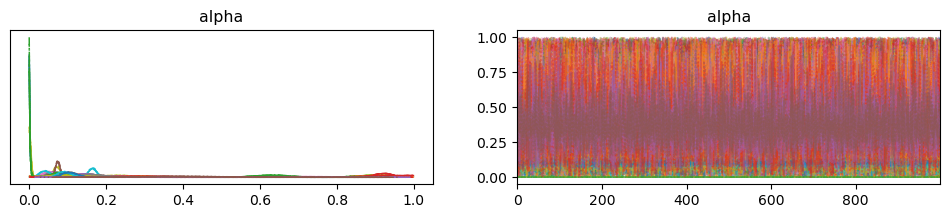

In [38]:
az.plot_trace(tr, var_names='alpha')

In [39]:
az.summary(tr, var_names='alpha')

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha[0],0.002,0.002,0.000,0.005,0.000,0.000,4958.0,2334.0,1.0
alpha[1],0.093,0.030,0.038,0.146,0.000,0.001,4605.0,2499.0,1.0
alpha[2],0.899,0.046,0.820,0.990,0.001,0.001,2708.0,1601.0,1.0
alpha[3],0.207,0.073,0.086,0.344,0.001,0.002,6538.0,2643.0,1.0
alpha[4],0.059,0.018,0.024,0.092,0.000,0.000,3914.0,2509.0,1.0
...,...,...,...,...,...,...,...,...,...
alpha[81],0.479,0.272,0.062,0.969,0.003,0.003,6763.0,2834.0,1.0
alpha[82],0.002,0.002,0.000,0.005,0.000,0.000,4904.0,2179.0,1.0
alpha[83],0.375,0.258,0.002,0.849,0.004,0.003,5143.0,2607.0,1.0
alpha[84],0.392,0.187,0.064,0.736,0.003,0.004,5055.0,2120.0,1.0


In [40]:
tr

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data

# Add intercept

In [43]:
# try alpha as beta distribution
with pm.Model() as m2:
  
    intercept = pm.Normal('intercept', 0,.5, shape=n_subj)  
    alpha = pm.Beta('alpha', 1,1, shape=n_subj)
    beta = pm.Normal('beta',0, .5, shape=n_subj)
    eps = pm.HalfNormal('eps', 1)
    
    Qs = 0.5 * pt.ones((n_subj,2), dtype='float64') # set values for boths stimuli (CS+, CS-)
    vec = 0.5 * pt.ones((n_subj,1), dtype='float64') # vector to save the relevant stimulus's expactation
    
    [Qs,vec, pe], updates = pytensor.scan(
        fn=update_Q,
        sequences=[stim, shock],
        outputs_info=[Qs, vec, None],
        non_sequences=[alpha, n_subj])
   
    
    vec_ = intercept[subj] + vec[trials, subj,0] * beta[subj]
    
    scrs = pm.Normal('scrs', vec_, eps, observed=scrMat) 
    
    trI = pm.sample(chains=4, return_inferencedata=True,
                   idata_kwargs={"log_likelihood": True},
                   nuts_sampler="blackjax"
                  )

Running window adaptation


The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details


In [44]:
az.summary(trI)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
intercept[0],0.996,0.175,0.689,1.314,0.005,0.003,1284.0,1924.0,1.00
intercept[1],0.127,0.140,-0.136,0.383,0.002,0.002,3935.0,2333.0,1.00
intercept[2],0.207,0.067,0.080,0.331,0.001,0.001,7994.0,2957.0,1.00
intercept[3],0.026,0.117,-0.200,0.231,0.002,0.002,4856.0,2762.0,1.00
intercept[4],0.491,0.133,0.235,0.727,0.002,0.002,4030.0,2917.0,1.00
...,...,...,...,...,...,...,...,...,...
alpha[82],0.448,0.261,0.012,0.863,0.009,0.006,1006.0,1351.0,1.01
alpha[83],0.416,0.279,0.000,0.889,0.004,0.003,5521.0,2887.0,1.00
alpha[84],0.416,0.231,0.036,0.841,0.003,0.003,4719.0,2872.0,1.00
alpha[85],0.354,0.175,0.069,0.688,0.003,0.003,4678.0,2555.0,1.00


In [45]:
az.compare({'model1': tr, 'model2_intercept':trI}) 

/home/oad4/.conda/envs/pymc_env/lib/python3.13/site-packages/arviz/stats/stats.py:797: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/home/oad4/.conda/envs/pymc_env/lib/python3.13/site-packages/arviz/stats/stats.py:797: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
model1,0,-4336.783526,202.664562,0.000000,0.699884,187.924223,0.000000,True,log
model2_intercept,1,-4428.996426,218.809459,92.212901,0.300116,186.091196,36.221854,True,log


So, the second model is problematic, probably needs some hyperparametarization and such. Moving on to better models

# Model using hyperparameter in different way
- For reference:
https://docs.pymc.io/en/v3/pymc-examples/examples/case_studies/hierarchical_partial_pooling.html

In [46]:
with pm.Model() as m5:
    
    # α
    phi = pm.Uniform("phi", lower=0.0, upper=1.0)
    kappa_log = pm.Exponential("kappa_log", lam=1.5)
    kappa = pm.Deterministic("kappa", pt.exp(kappa_log))
    alpha = pm.Beta("alpha", alpha=phi * kappa, beta=(1.0 - phi) * kappa, shape=n_subj)
    
    # β
    beta_h = pm.Normal('beta_h', 0,1)
    beta_sd = pm.HalfNormal('beta_sd', 5)
    beta = pm.Normal('beta',beta_h, beta_sd, shape=n_subj)
       
    eps = pm.HalfNormal('eps', 5)
    
    Qs = 0.5 * pt.ones((n_subj,2), dtype='float64') # set values for boths stimuli (CS+, CS-)
    vec = 0.5 * pt.ones((n_subj,1), dtype='float64') # vector to save the relevant stimulus's expactation
    
    [Qs,vec, pe], updates = pytensor.scan(
        fn=update_Q,
        sequences=[stim, shock],
        outputs_info=[Qs, vec, None],
        non_sequences=[alpha, n_subj])
   
     
    vec_ = vec[trials, subj,0] * beta[subj]
    # add matrix of expected values (trials X subjects)
    ev = pm.Deterministic('expected_value', vec_)
    # add PE
    pe = pm.Deterministic('pe', pe)
    
    scrs = pm.Normal('scrs', vec_, eps, observed=scrMat) 
    trH_phi = pm.sample(chains=4, return_inferencedata=True,
                   idata_kwargs={"log_likelihood": True},
                   nuts_sampler="blackjax"
                  )

Running window adaptation


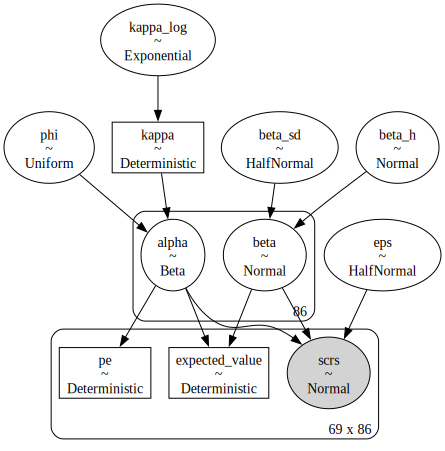

In [48]:
pm.model_to_graphviz(m5)

In [47]:
az.compare({'simpleModel':tr, 'hierarchy':trH_phi})

/home/oad4/.conda/envs/pymc_env/lib/python3.13/site-packages/arviz/stats/stats.py:797: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/home/oad4/.conda/envs/pymc_env/lib/python3.13/site-packages/arviz/stats/stats.py:797: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
hierarchy,0,-4324.371546,203.914608,0.00000,0.742777,186.185207,0.000000,True,log
simpleModel,1,-4336.783526,202.664562,12.41198,0.257223,187.924223,7.388223,True,log


# Correlate with actual data

In [50]:
# grab alphas
alphas = trH_phi.posterior.stack(draws=('chain','draw'))
alphas = np.mean(alphas.alpha, axis=1)
alphas = pd.DataFrame({'subject': scr_clean['sub'].unique(), 'alphas':alphas })
alphas

,subject,alphas
0,sub-189,0.001345
1,sub-086,0.092349
2,sub-205,0.859506
3,sub-071,0.193767
4,sub-087,0.061544
...,...,...
81,sub-010,0.253418
82,sub-158,0.001339
83,sub-083,0.194296
84,sub-126,0.300809


In [51]:
# stack all chains
a = trH_phi.posterior.stack(draws=('chain','draw'))
a = a.expected_value
a.shape

(69, 86, 4000)

In [52]:
mean_a = np.mean(a, axis=2)
mean_a.shape

(69, 86)

In [53]:
# grab Prediction error
mean_pe = trH_phi.posterior.stack(draws=('chain','draw')).pe
mean_pe = np.mean(mean_pe, axis=2)


In [54]:
# calculate 
for i in np.arange(n_subj):
    cor1 = scipy.stats.pearsonr(scrMat[:,i], mean_a[:,i])
    print(cor1)

PearsonRResult(statistic=np.float64(-0.3328534015671996), pvalue=np.float64(0.0051973667637777495))
PearsonRResult(statistic=np.float64(0.5831310179632849), pvalue=np.float64(1.4582739716071797e-07))
PearsonRResult(statistic=np.float64(0.9575824299146314), pvalue=np.float64(6.323298299066291e-38))
PearsonRResult(statistic=np.float64(0.5437778242188198), pvalue=np.float64(1.3738975236921186e-06))
PearsonRResult(statistic=np.float64(0.4141194741089982), pvalue=np.float64(0.0004042107089284725))
PearsonRResult(statistic=np.float64(0.7137759392719824), pvalue=np.float64(5.820609811944006e-12))
PearsonRResult(statistic=np.float64(0.38741146111397384), pvalue=np.float64(0.0010063900921460217))
PearsonRResult(statistic=np.float64(0.1727329161159388), pvalue=np.float64(0.1558092236407676))
PearsonRResult(statistic=np.float64(0.5494463134343767), pvalue=np.float64(1.0121672136412374e-06))
PearsonRResult(statistic=np.float64(0.41162400405164806), pvalue=np.float64(0.00044160246589599087))
Pearso

In [55]:
# seems that some subjects are really problematic. 
# should consider removing them from analysis
scr_clean['sub'].unique()
mean_a_vec = np.reshape(mean_a.T, (69*86,1)) # reshape to fit dataframe
mean_pe_vec = np.reshape(mean_pe.T, (69*86,1)) # reshape PE

In [56]:
len(scr_clean)
scr_clean['expected_value'] = mean_a_vec.values
scr_clean['pe'] = mean_pe_vec.values

In [57]:
scr_clean['scr'] = scr_clean['CDA.AmpSum']

In [58]:
# save file
scr_clean.to_csv('scr_clean.csv', index=False)

In [95]:
# loading coupling data
amg_hipp = pd.read_csv('amg_hipp_fc_WholeROIs.csv')
# merging with scr and PE data
dfAll = pd.merge(scr_clean, amg_hipp, right_on=['subject','trialNo'], left_on=['sub','Event.Nr'])
# saving combined data for future analysis
dfAll.to_csv('scr_amg_hipp_all.csv', index=False)


# Model comparisons
- Counterfactual
- Pierce Hall
- RW (we already did)

In [91]:
def update_counterfactual(stim, reward, As, vec, alpha_chosen, alpha_counterfactual, n_subj):
    """
    Update Q table for both chosen and unchosen stimuli (counterfactual learning) using separate learning rates.
    
    The chosen stimulus is updated based on the actual reward with the learning rate alpha_chosen.
    The unchosen stimulus is updated with a counterfactual reward (what could have happened) using alpha_counterfactual.
    """
    
    # Prediction error for the chosen stimulus
    PE_chosen = reward - As[pt.arange(n_subj), stim]
    
    # Index of the unchosen stimulus (opposite of stim)
    stim_opposite = 1 - stim
    
    # Counterfactual prediction error for the unchosen stimulus
    PE_unchosen = (1 - reward) - As[pt.arange(n_subj), stim_opposite]
    
    # Update chosen stimulus value with its own learning rate
    As = pt.set_subtensor(As[pt.arange(n_subj), stim], 
                          As[pt.arange(n_subj), stim] + alpha_chosen * PE_chosen)
    
    # Update unchosen stimulus value with a separate counterfactual learning rate
    As = pt.set_subtensor(As[pt.arange(n_subj), stim_opposite], 
                          As[pt.arange(n_subj), stim_opposite] + alpha_counterfactual * PE_unchosen)
    
    # Update vec based on the new As values
    vec = pt.set_subtensor(vec[pt.arange(n_subj), 0], 
                           pt.switch(pt.eq(stim, 1), 
                                     As[pt.arange(n_subj), 1], 
                                     As[pt.arange(n_subj), 0]))
    return As, vec, PE_chosen


# Learning process (Pearce-Hall)
def update_Q_PH(stim_t, shock_t, Qs_tm1, alpha_tm1, vec_tm1, lambda_, n_subj):
        PE_t = shock_t - Qs_tm1[pt.arange(n_subj), stim_t]

        # Update dynamic learning rate
        alpha_t = lambda_ * pt.abs(PE_t) + (1 - lambda_) * alpha_tm1

        # Update Q-values
        updated_Qs = pt.set_subtensor(
            Qs_tm1[pt.arange(n_subj), stim_t],
            Qs_tm1[pt.arange(n_subj), stim_t] + alpha_t * PE_t
        )

        # Update expected value vector
        updated_vec = pt.set_subtensor(
            vec_tm1[pt.arange(n_subj), 0],
            pt.switch(pt.eq(stim_t, 1),
                      updated_Qs[pt.arange(n_subj), 1],
                      updated_Qs[pt.arange(n_subj), 0])
        )

        return updated_Qs, alpha_t, updated_vec, PE_t

In [85]:
with pm.Model() as cf:
    
    # α
    phi = pm.Uniform("phi", lower=0.0, upper=1.0)
    kappa_log = pm.Exponential("kappa_log", lam=1.5)
    kappa = pm.Deterministic("kappa", pt.exp(kappa_log))
    alpha1 = pm.Beta("alpha1", alpha=phi * kappa, beta=(1.0 - phi) * kappa, shape=n_subj)
    
    # β
    beta_h = pm.Normal('beta_h', 0,1)
    beta_sd = pm.HalfNormal('beta_sd', 5)
    beta = pm.Normal('beta',beta_h, beta_sd, shape=n_subj)
    
    # counterfactual alpha
    phi2 = pm.Uniform("phi_c", lower=0.0, upper=1.0)
    kappa_log2 = pm.Exponential("kappa_log_c", lam=1.5)
    kappa2 = pm.Deterministic("kappa_c", pt.exp(kappa_log2))
    alpha2 = pm.Beta("alpha_c", alpha=phi2 * kappa2, beta=(1.0 - phi2) * kappa2, shape=n_subj)
    
    eps = pm.HalfNormal('eps', 5)
    
    # Initialize As (value estimates) and vec (prediction error tracking)
    As  = 0 * pt.ones((n_subj, 2), dtype='float64')
    vec = 0 * pt.ones((n_subj, 1), dtype='float64')
    
    # Update As and vec using the counterfactual learning function with separate learning rates
    [As, vec, pe], _ = pytensor.scan(  
        fn            = update_counterfactual,  # Use the counterfactual update function
        sequences     = [stim, shock],
        outputs_info  = [As, vec, None],
        non_sequences = [alpha1, alpha2, n_subj]
    )
    
    vec_ = vec[trials, subj,0] * beta[subj]
    # add matrix of expected values (trials X subjects)
    ev = pm.Deterministic('expected_value', vec_)
    # add PE
    pe = pm.Deterministic('pe', pe)
    
    scrs = pm.Normal('scrs', vec_, eps, observed=scrMat) 
    tr_cf = pm.sample(chains=4, return_inferencedata=True,
                   idata_kwargs={"log_likelihood": True},
                   nuts_sampler="blackjax"
                  )

Running window adaptation


The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


In [87]:
az.compare({'hierarchy':trH_phi,
           'counterFactual': tr_cf})

/home/oad4/.conda/envs/pymc_env/lib/python3.13/site-packages/arviz/stats/stats.py:797: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/home/oad4/.conda/envs/pymc_env/lib/python3.13/site-packages/arviz/stats/stats.py:797: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
hierarchy,0,-4324.371546,203.914608,0.000000,0.900996,186.185207,0.00000,True,log
counterFactual,1,-5215.989158,229.278084,891.617613,0.099004,189.743756,108.17708,True,log


## Pearce Hall

In [93]:
## Pearce-Hall
Qs_init = 0.5 * pt.ones((n_subj, 2), dtype='float64')
alpha_init = 0.5 * pt.ones((n_subj,), dtype='float64')  # starting alpha per subject
vec_init = 0.5 * pt.ones((n_subj, 1), dtype='float64')

# Model
with pm.Model() as model_scr_ph:
    
    # α
    phi = pm.Uniform("phi", lower=0.0, upper=1.0)
    kappa_log = pm.Exponential("kappa_log", lam=1.5)
    kappa = pm.Deterministic("kappa", pt.exp(kappa_log))
    alpha1 = pm.Beta("alpha1", alpha=phi * kappa, beta=(1.0 - phi) * kappa, shape=n_subj)
    
    # β
    beta_h = pm.Normal('beta_h', 0,1)
    beta_sd = pm.HalfNormal('beta_sd', 5)
    beta = pm.Normal('beta',beta_h, beta_sd, shape=n_subj)
    
    # counterfactual alpha
    phi2 = pm.Uniform("phi_c", lower=0.0, upper=1.0)
    kappa_log2 = pm.Exponential("kappa_log_c", lam=1.5)
    kappa2 = pm.Deterministic("kappa_c", pt.exp(kappa_log2))
    alpha2 = pm.Beta("alpha_c", alpha=phi2 * kappa2, beta=(1.0 - phi2) * kappa2, shape=n_subj)

    # Group-level stickiness (lambda) for updating alpha
    lambda_ = pm.Beta("lambda_", alpha=2, beta=2, shape=n_subj)
    
    eps = pm.HalfNormal('eps', 5)
    
    # Initialize As (value estimates) and vec (prediction error tracking)
    As  = 0 * pt.ones((n_subj, 2), dtype='float64')
    vec = 0 * pt.ones((n_subj, 1), dtype='float64')
    
    (Qs, alphas, vec, pe), updates = pytensor.scan(
        fn=update_Q_PH,
        sequences=[stim, shock],
        outputs_info=[Qs_init, alpha_init, vec_init, None],
        non_sequences=[lambda_, n_subj]
    )
    
    vec_ = vec[trials, subj,0] * beta[subj]
    # add matrix of expected values (trials X subjects)
    ev = pm.Deterministic('expected_value', vec_)
    # add PE
    pe = pm.Deterministic('pe', pe)
    
    scrs = pm.Normal('scrs', vec_, eps, observed=scrMat) 
    tr_ph = pm.sample(chains=4, return_inferencedata=True,
                   idata_kwargs={"log_likelihood": True},
                   nuts_sampler="blackjax"
                  )

Running window adaptation


There were 30 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


In [94]:
az.compare({'hierarchy':trH_phi,
           'counterFactual': tr_cf,
           'Pearce-Hall': tr_ph})

/home/oad4/.conda/envs/pymc_env/lib/python3.13/site-packages/arviz/stats/stats.py:797: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/home/oad4/.conda/envs/pymc_env/lib/python3.13/site-packages/arviz/stats/stats.py:797: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/home/oad4/.conda/envs/pymc_env/lib/python3.

,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
hierarchy,0,-4324.371546,203.914608,0.000000,9.996192e-01,186.185207,0.000000,True,log
counterFactual,1,-5215.989158,229.278084,891.617613,3.806123e-04,189.743756,108.177080,True,log
Pearce-Hall,2,-5450.746380,148.192377,1126.374834,1.405690e-07,161.458860,96.203729,True,log
